### Case Study

Many strategies can be highly profitable depending on whether you are in an upward trending, downward trending or oscillating market. However, how can you tell what market you are in and in addition do this without an subjective bias?

Hidden Markov Models allow us to determine any number of states we like, given inputs such as returns and volatility (or any inputs of your choosing), to help ascertain what state - or regime - the market is in. This is part of a type of analysis known as Regime identification.

### Imports

In [1]:
import pandas as pd
import numpy as np

from pyhhmm.gaussian import GaussianHMM
import yfinance as yf

import matplotlib.pyplot as plt

/Users/anoguera/anaconda3/envs/MLTrading/lib/python3.9/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


### Data Management

In [2]:
# Data Extraction
start_date = "2017-01-01"
end_date = "2024-12-31"
symbol = "BTC-USD"
data = yf.download(symbol, start=start_date, end=end_date)
data = data[["Open", "High", "Low", "Adj Close", "Volume"]]

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Add Returns and Range
df = data.copy()
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
df.head()

,Open,High,Low,Adj Close,Volume,Returns,Range
Date,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,-0.122410,0.308302
2017-01-06,1014.239990,1046.810059,883.943970,902.200989,351876000,-0.109711,0.184249


In [4]:
# Structure Data
X_train = df[["Returns", "Range"]]
X_train.head()

,Returns,Range
Date,,
2017-01-02,0.023464,0.034803
2017-01-03,0.021620,0.022005
2017-01-04,0.106233,0.110130
2017-01-05,-0.122410,0.308302
2017-01-06,-0.109711,0.184249


### HMM Learning

In [5]:
# Train Model
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])

(<pyhhmm.gaussian.GaussianHMM at 0x306618340>, 13460.50009745965)

In [6]:
# Check Results
hidden_states = model.predict([X_train.values])[0]
print(hidden_states[:40])
len(hidden_states)

[0 0 1 2 2 2 3 0 0 2 2 1 0 0 0 1 3 0 0 0 0 0 3 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 3 2 3]


2905

In [7]:
# Regime state means for each feature
model.means

array([[ 0.00414923,  0.02692963],
       [ 0.04869809,  0.07076172],
       [-0.0237477 ,  0.14218351],
       [-0.02722823,  0.05865113]])

In [8]:
# Regime state covars for each feature
model.covars

array([[[ 2.12881710e-04,  6.98748546e-05],
        [ 6.98748546e-05,  1.57828514e-04]],

       [[ 1.09992487e-03,  9.44242647e-04],
        [ 9.44242647e-04,  1.01977542e-03]],

       [[ 5.98057613e-03, -1.67635009e-03],
        [-1.67635009e-03,  5.37441481e-03]],

       [[ 5.69186862e-04, -3.01410791e-04],
        [-3.01410791e-04,  5.02239495e-04]]])

### Data Visualization

In [9]:
# Asegúrate de que el índice es de tipo datetime
df.index = pd.to_datetime(df.index)

# Estructurar los precios y estados
prices = df["Adj Close"].values.astype(float)
hidden_states = np.array(hidden_states)

# Crear un DataFrame con precios y estados para facilidad
data = pd.DataFrame({
    "Price": prices,
    "State": hidden_states
}, index=df.index)

data.head()

,Price,State
Date,,
2017-01-02,1021.750000,0
2017-01-03,1043.839966,0
2017-01-04,1154.729980,1
2017-01-05,1013.380005,2
2017-01-06,902.200989,2


In [10]:
print(data["State"].value_counts())

0    1703
3     591
1     419
2     192
Name: State, dtype: int64


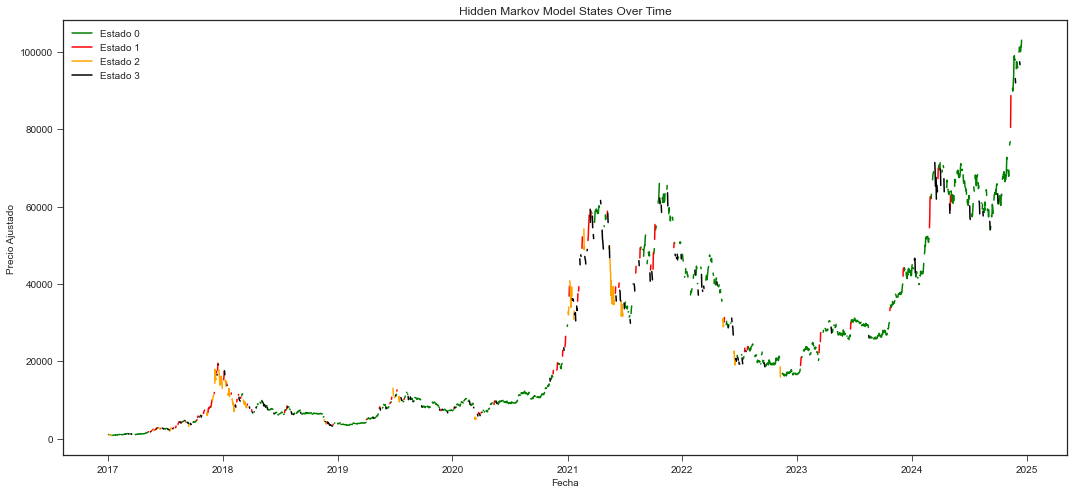

In [11]:
# Inicializar una figura
fig, ax = plt.subplots(figsize=(18, 8))

# Iterar por cada estado y graficar
colors = ["green", "red", "orange", "black"]
for state, color in enumerate(colors):
    # Crear una serie que mantenga los precios solo para el estado actual
    state_prices = np.where(data["State"] == state, data["Price"], np.nan)
    ax.plot(data.index, state_prices, label=f"Estado {state}", color=color)

# Formato del gráfico
ax.set_title("Hidden Markov Model States Over Time")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio Ajustado")
ax.legend()
plt.show()

### Conclusion

Although work is still yet to be done in the following notebook, we can cleary see from the chart above, that the Hidden Markov Model has been able to identify market regimes based on returns and volatility behaviour.

### Useful Resources

HMM Colab Version with Backtest: https://colab.research.google.com/drive/12qzR8SrhfhQDBImKYQqUKdj6n60E9jNp?usp=sharing